In [ ]:
import torch.nn as nn
import torch
import random
from torch.utils.data import DataLoader, TensorDataset
from torchmetrics import HingeLoss
import numpy as np
from matplotlib import pyplot as plt
from datetime import datetime

In [344]:
def simple_data_generator(
        k: int = 3,
        n: int = 20,
        ):
    parity_bits = random.sample(range(n), k)
    num = 2 ** n
    x = torch.zeros((num, n), dtype=torch.float32)
    for i in range(num):
        x[i] = torch.tensor(
            list(map(int, bin(i)[2:].zfill(n))), dtype=torch.float
            )
    y = x[:, parity_bits].sum(dim=1) % 2
    # y = 2 * y - 1
    y = y.reshape(-1, 1)

    return x, y, parity_bits

In [ ]:
class MyHingeLoss(nn.Module):

    def __init__(self):
        super(MyHingeLoss, self).__init__()

    def forward(self, output, target):
        y_hat = output * 2 - 1
        y_true = target * 2 - 1
        hinge_loss = 1 - torch.mul(y_hat, y_true)
        hinge_loss = torch.clamp(hinge_loss, min=0)
        return (hinge_loss ** 2).mean()

In [ ]:
class FFNN(nn.Module):
    def __init__(self, n, k: int = 3):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(out_features=k, in_features=n),
            nn.ReLU(),
            nn.Linear(out_features=1, in_features=k),
        )
        # self.initialize_params(k, n)
        # self.freeze_params()
    def initialize_params(self, k, n):
        with torch.no_grad():
            first_layer = self.network[0]
            first_layer.bias.data = -torch.arange(k).float() - 0.5
            first_layer.weight.normal_(mean=k/n, std=1.0)
            # first_layer.weight.data = torch.ones(k, n) * k / n
            second_layer = self.network[2]
            weights = torch.tensor(
                [((-1) ** i) * (2 + 4 * i) for i in range(k)],
                dtype=torch.float32
                )
            second_layer.weight.data = weights.view(1, -1)  # Shape: (k, 1)
            second_layer.bias.data = torch.Tensor([0])

    def freeze_params(self):
        self.network[0].bias.requires_grad = False
        self.network[0].weight.requires_grad = True
        self.network[2].weight.requires_grad = False
        self.network[2].bias.requires_grad = False

    def forward(self, x):
        return self.network(x)

In [ ]:
length = 5
k = 3

In [ ]:
def test(model, x, y):
    pred = model(x)
    predicted_classes = (pred >= 0.5).float()
    correct_predictions = (predicted_classes == y).sum()
    accuracy = correct_predictions / y.size(0)
    return accuracy.item()

In [ ]:

epochs = 10000
loss_fn = MyHingeLoss()
x, y, bits = data_generator(k, length)

In [ ]:


dataset = TensorDataset(x, y)
dataloader = DataLoader(dataset)


In [388]:
def plot_loss_percentile(all_losses, interval=200, title="no title"):
    losses = np.array(all_losses)

    epochs = np.arange(losses.shape[1]) * interval  # Scale x-axis
    median = np.median(losses, axis=0)
    q20 = np.percentile(losses, 20, axis=0)
    q80 = np.percentile(losses, 80, axis=0)
    q10 = np.percentile(losses, 10, axis=0)
    q90 = np.percentile(losses, 90, axis=0)

    plt.plot(epochs, median, color='black', label='Median loss')
    plt.fill_between(epochs, q20, q80, alpha=0.3, label='20–80%')
    plt.fill_between(epochs, q10, q90, alpha=0.2, label='10–90%')

    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.ylim(0, 3)
    plt.title(title)
    plt.legend()
    plt.grid(True)



In [ ]:
import math

def simple_embedding(x):
    length = len(x)
    token_embedding = torch.stack(
        [torch.tensor(x), 1 - torch.tensor(x)], dim=1
        )

    positions = torch.arange(
        length, dtype=torch.float32
        ) * (2 * math.pi / length)
    positional_embeddings = torch.stack(
        [torch.cos(positions), torch.sin(positions)], dim=1
        )
    encoded_tensor = torch.cat([token_embedding, positional_embeddings], dim=1)
    return encoded_tensor

In [ ]:

def data_generator(
        num_data: int,
        k: int = 4,
        n: int = 20,
        ):
    parity_bits = random.sample(range(n), k)
    # parity_bits = [2, 4, 15]
    num = 2 ** n
    x = torch.zeros((num, n), dtype=torch.float32)
    for i in range(num):
        x[i] = torch.tensor(
            list(map(int, bin(i)[2:].zfill(n))), dtype=torch.float
            )
    y = x[:, parity_bits].sum(dim=1) % 2
    # y = 2 * y - 1
    y = y.reshape(-1, 1)
    x_embeddings = torch.stack([simple_embedding(row) for row in x])
    indices = torch.randperm(num)[:num_data]
    data_embeddings = x_embeddings[indices]
    labels = y[indices]

    return x_embeddings, y, data_embeddings, labels, parity_bits


In [ ]:
import torch.nn.functional as F
class Attention(nn.Module):
    def __init__(self, dim):
        super(Attention, self).__init__()
        self.A = nn.Parameter(torch.zeros(dim, dim))
        self.v0 = torch.zeros(dim)
        self.v0[0] = 1
        theta = torch.rand(1) * 2 * torch.pi
        with torch.no_grad():
            self.A[0, 2] = torch.cos(theta)
            self.A[0, 3] = torch.sin(theta) 
        self.mask = torch.zeros(dim, dim)
        self.mask[0, 2] = 1
        self.mask[0, 3] = 1

    def forward(self, v):
        A_masked = self.A * self.mask
        Av0 = torch.matmul(self.v0, A_masked)
        scores = torch.matmul(v, Av0.unsqueeze(-1)).squeeze(-1)
        temperature = 1 / 10
        scores /= temperature
        attention_weights = F.softmax(scores, dim=-1)
        weighted_sum = torch.matmul(attention_weights.unsqueeze(1), v).squeeze(1)
        return weighted_sum

In [ ]:

class parity_NN(nn.Module):
    def __init__(self, k: int = 3) -> None:
        super().__init__()
        self.attention_heads = [Attention(dim=4) for _ in range(k)]
        self.network = nn.Sequential(
            nn.Linear(4, k),
            nn.ReLU(),
            nn.Linear(k, 1),
            )
        self.freeze_params()
        self.initialize_params(k)

    def initialize_params(self, k):
        with torch.no_grad():
            first_layer = self.network[0]
            weight_pattern = torch.zeros(k, 4)

            for i in range(k):
                weight_pattern[i, :] = torch.tensor([k, 0, 0, 0])

            first_layer.weight.data = weight_pattern
            first_layer.bias.data = -torch.arange(k).float() - 0.5

            second_layer = self.network[2]
            weights = torch.tensor(
                [((-1) ** i) * (2 + 4 * i) for i in range(k)],
                dtype=torch.float32
                )
            second_layer.weight.data = weights.view(1, -1)
            second_layer.bias.data = torch.Tensor([0])

    def freeze_params(self):
        for param in self.network.parameters():
            param.requires_grad = False

    def forward(self, x):
        attention_vectors = []
        for head in self.attention_heads:
            attn_output = head(x)
            attention_vectors.append(attn_output)
        stacked_tensors = torch.stack(attention_vectors)
        attention_vectors = stacked_tensors.mean(dim=0)
        # attention_vectors = torch.concat(attention_vectors, dim=1)
        return self.network(attention_vectors)


In [ ]:
from tqdm import tqdm
def record_loss_trend(model_name, length, k, num_runs = 1000, epochs=10000, interval = 200):
    all_losses = []
    loss_fn = HingeLoss(task="binary")
    squared_fn = MyHingeLoss()
    record_epochs = list(range(0, epochs, interval)) 
    for run in tqdm(range(num_runs)):
        if model_name == parity_NN:
            x, y, _, _, _ = data_generator(30, k, length)
            model = model_name(2)
            attention_params = []
            for i in range(k):
                attention_params += list(
                    model.attention_heads[i].parameters()
                )
            optimizer = torch.optim.Adam(attention_params, lr=4e-3)
        elif model_name == FFNN:
            x, y, _ = simple_data_generator(k, length)
            model = FFNN(length, k)
            optimizer = torch.optim.Adam(model.parameters(), lr = 5e-3)
        model.train()
        run_losses = []
        

        for epoch in range(epochs):
            pred = model(x)
            loss = loss_fn(pred, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if epoch in record_epochs:
                run_losses.append(loss.item())
        all_losses.append(run_losses)
    return np.array(all_losses)

In [ ]:
length = 3
k = 2
losses = record_loss_trend(parity_NN, length, k, 1000, 200, 1)

  0%|          | 0/100 [00:00<?, ?it/s]/tmp/ipykernel_16399/52618165.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  [torch.tensor(x), 1 - torch.tensor(x)], dim=1
100%|██████████| 100/100 [00:25<00:00,  3.89it/s]


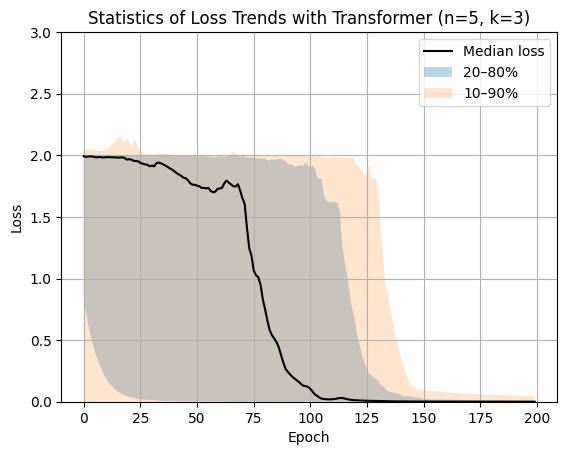

In [389]:
plot_loss_percentile(losses, 1, title="Statistics of Loss Trends with Transformer (n=5, k=3)")
plt.savefig("attention_200_runs.png")

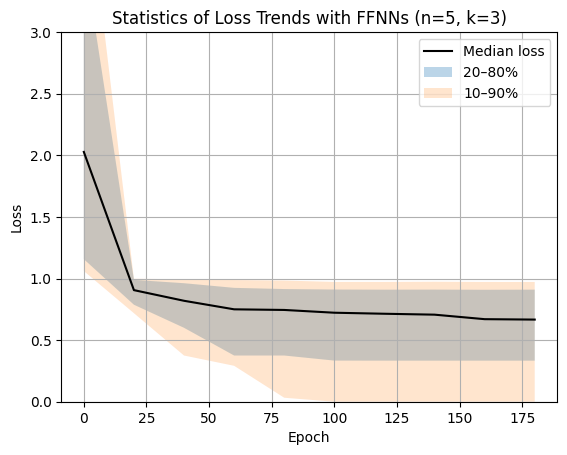

In [394]:
ffnn_losses = np.load(open("ffnn_losses.npy", "rb"))
plot_loss_percentile(ffnn_losses[:,:10], 20, title="Statistics of Loss Trends with FFNNs (n=5, k=3)")
plt.savefig("ffnn_200_runs.png")

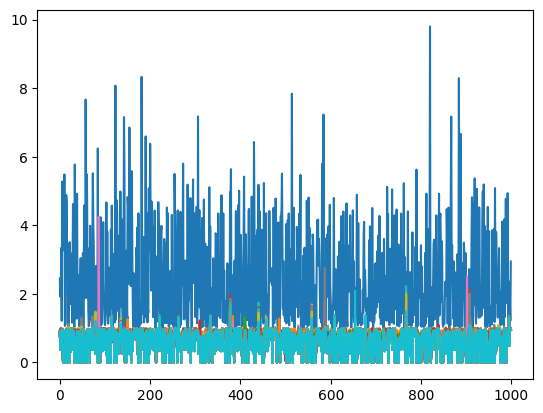

In [384]:
plt.plot(ffnn_losses)

In [307]:
length = 3
k = 2
epochs = 3000
batch_size = 2**length
loss_fn = HingeLoss(task="binary")
SHL_fn = MyHingeLoss()
x, y, _, _, bits = data_generator(30, k, length)
dataloader = DataLoader(dataset, shuffle=True)
parity_network = parity_NN(k)
attention_params = []
for i in range(k):
    attention_params += list(
        parity_network.attention_heads[i].parameters()
        )
total_weights = []

optimizer = torch.optim.Adam(attention_params, lr=4e-3)
parity_network.train()
for i in range(epochs):
    pred = parity_network(x)
    loss = loss_fn(pred, y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if i % 10 == 0:
        sql = SHL_fn(pred, y)
        print(f"epoch: {i}, loss: {sql:>7f}.")

            
parity_network.eval()

print(test(parity_network, x, y))

/tmp/ipykernel_16399/52618165.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  [torch.tensor(x), 1 - torch.tensor(x)], dim=1


epoch: 0, loss: 2.000000.
epoch: 10, loss: 2.000000.
epoch: 20, loss: 1.999999.
epoch: 30, loss: 1.999997.
epoch: 40, loss: 1.999989.
epoch: 50, loss: 1.999953.
epoch: 60, loss: 1.999787.
epoch: 70, loss: 1.999198.
epoch: 80, loss: 2.004521.
epoch: 90, loss: 2.222960.
epoch: 100, loss: 2.442185.
epoch: 110, loss: 1.058118.
epoch: 120, loss: 0.120860.
epoch: 130, loss: 0.020164.
epoch: 140, loss: 0.008861.
epoch: 150, loss: 0.006189.
epoch: 160, loss: 0.005215.
epoch: 170, loss: 0.004730.
epoch: 180, loss: 0.004414.
epoch: 190, loss: 0.004167.
epoch: 200, loss: 0.003954.
epoch: 210, loss: 0.003760.
epoch: 220, loss: 0.003581.
epoch: 230, loss: 0.003415.
epoch: 240, loss: 0.003259.
epoch: 250, loss: 0.003114.
epoch: 260, loss: 0.002978.
epoch: 270, loss: 0.002850.
epoch: 280, loss: 0.002730.
epoch: 290, loss: 0.002618.
epoch: 300, loss: 0.002512.
epoch: 310, loss: 0.002412.
epoch: 320, loss: 0.002318.
epoch: 330, loss: 0.002229.
epoch: 340, loss: 0.002146.
epoch: 350, loss: 0.002067.
epo

In [295]:

def test(model, x, y):
    pred = model(x)
    # print(y[:5])
    # print(pred[:5])
    predicted_classes = (pred >= 0.5).float()
    correct_predictions = (predicted_classes == y).sum()
    accuracy = correct_predictions / y.size(0)
    return accuracy.item()